# **IMPORT LIBRARIES**

In [ ]:
#!pip install albumentations > /dev/null
#!pip install -U efficientnet==0.0.4
!pip install -U segmentation-models
#!pip install keras==2.3.1
#!pip install tensorflow

In [13]:
import numpy as np
import pandas as pd
import gc
import tensorflow.keras

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.callbacks import  ModelCheckpoint
#from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
#from keras.layers import Conv2D, Concatenate, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Concatenate, MaxPooling2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
#from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
#from keras.eras.engine import InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import multiply


from tensorflow.keras import optimizers
#from keras.legacy import interfaces
from tensorflow.python.keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from tensorflow.python.keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from tensorflow.python.keras.layers.core import Activation, SpatialDropout2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from tensorflow.keras.regularizers import l2
from tensorflow.python.keras.layers.core import Dense, Lambda
from tensorflow.python.keras.layers.merge import concatenate, add
from tensorflow.python.keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image
import cv2

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
    
%matplotlib inline

# **Data Preprocessing**

In [14]:
image_path = "/content/drive/MyDrive/Vin Deep Learning/Demo  Montgomery County and Shenzhen Hospital/data/Shenzhen Hospital/CXR_png/"
mask_path = "/content/drive/MyDrive/Vin Deep Learning/Demo  Montgomery County and Shenzhen Hospital/data/Shenzhen Hospital/mask/"

In [15]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [16]:
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))

Total mask that has modified name: 566


In [17]:
test_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))

In [18]:
#tạo list id của mask
l_mask = list(test_files) + [x + '.png' for x in check]
l_mask.sort()

In [19]:
#tạo list id của image
l_img = [x.split('_mask')[0] for x in check] #lấy id của image 
l_img = list(test_files) + [x + '.png' for x in l_img]
l_img.sort()

In [20]:
df = pd.DataFrame()
df['images'] = l_img
df['mask'] = l_mask

In [21]:
df['images'] = image_path + df['images']
df['mask'] = mask_path + df['mask']

In [22]:
df

,images,mask
0,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
1,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
2,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
3,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
4,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
...,...,...
561,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
562,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
563,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...
564,/content/drive/MyDrive/Vin Deep Learning/Demo ...,/content/drive/MyDrive/Vin Deep Learning/Demo ...


In [23]:
print('No. of train files:', len(df))


No. of train files: 566


In [24]:
train_im_path = df['images'].tolist()
train_mask_path = df['mask'].tolist()
# val_im_path = val_df['images'].tolist()
# val_mask_path = val_df['mask'].tolist()
img_size = 1024

In [27]:
#Data Augumentation : gia tăng dữ liệu
#Customize: Image Datasets có size khác nhau, preprocessing (giảm nhiễu, crop, zoom image,...)
#Load từng batch lên memory
#DataGenerator cần xác định size của 1 batch, số lượt steps training (files trong 1 epoch)


class DataGenerator(tensorflow.keras.utils.Sequence):
    
    def __init__(self,train_im_path = train_im_path,train_mask_path = train_mask_path,
                 augmentations = None,img_size = img_size,batch_size = 64,nchannels = 3,shuffle = True):
        
        '''
        batch_size: kích thước của 1 batch
        n_channels: số lượng channels của ảnh
        shuffle: có shuffle dữ liệu sau mỗi epoch hay không?
        '''
        #self.train_im_paths = list(filepath)
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.nchannels = nchannels
        self.shuffle = shuffle 
        self.augmentations = augmentations #gia tăng
        self.on_epoch_end()
    
    def __len__(self):
        #return số lượng file trong 1 epoch
        return int(np.ceil(len(self.train_im_path)/ self.batch_size)) #566/64
    
    def __getitem__(self,index):
        '''
        params: 
          index: index của batch
        return:
          X, y cho batch thứ index
        '''
        #lấy ra indexes của batch thứ index
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.train_im_path))]
        #list image + mask trong 1 batch
        list_im_ids = [self.train_im_path[i] for i in indexes]
        list_mask_ids = [self.train_mask_path[i] for i in indexes]
        #khởi tạo data
        X,y = self.data_generation(list_im_ids,list_mask_ids)
        
        return X,np.array(y) / 255.
    
    def on_epoch_end(self):
        #shuffle data khi epochs end hoặc start
        self.indexes = np.arange(len(self.train_im_path))
        if(self.shuffle):
            np.random.shuffle(self.indexes)
    
    def data_generation(self,list_im_ids,list_mask_ids):
        '''
        params:
          list_im_ids, list_mask_ids: list các filenames trong 1 batch
        return:
          trả về giá trị cho 1 batch
        '''
        X = np.empty((len(list_im_ids),self.img_size,self.img_size,self.nchannels))
        y = np.empty((len(list_mask_ids),self.img_size,self.img_size,1)) #channel của mask = 1
        
        #khởi tạo data
        for i,(img_path, mask_path) in enumerate(zip(list_im_ids,list_mask_ids)):
            #print(mask_path)
            mask = np.array(Image.open(mask_path))
            #plt.imshow(mask)
            img = np.array(Image.open(img_path))
            #img = np.true_divide(img,255.)
           # plt.imshow(img,cmap = 'bone')
            if(len(img.shape) == 2):
                img = np.repeat(img[...,np.newaxis],3,2)
            
           # plt.imshow(img,cmap = 'bone')
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[...,np.newaxis]
            y[y > 0] = 255
        return np.uint8(X),np.uint8(y)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

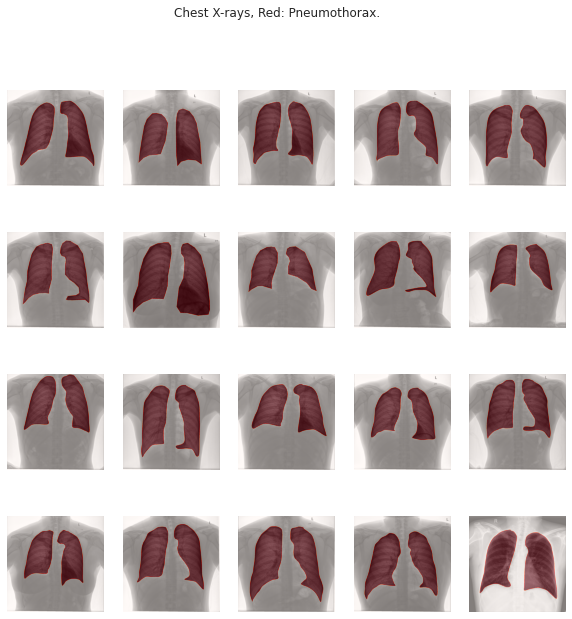

In [28]:
a = DataGenerator(batch_size=20,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 20
grid_width = 5
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(10, 10))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# **Modeling**

In [29]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [30]:
def UNet(image_size):
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [31]:
def unet(input_size=(256,256,3)):
    inputs = keras.layers.Input((img_size, img_size, 3))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [44]:
#!pip install tensorflow==2.1.0
!pip install keras==2.3.1

     |████████████████████████████████| 378kB 4.1MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [55]:
from keras.utils import generic_utils
from keras.legacy import interfaces
import segmentation_models as sm
from tensorflow.python.keras import engine
from keras.engine import Layer, InputSpec

model = sm.Unet('seresnet34', input_shape=(img_size,img_size,3), encoder_weights='imagenet',decoder_block_type='transpose')

ModuleNotFoundError: ignored